# Predicting Fernando Alonso position in the Spanish Grand Prix in 2023.

### Main Goal

Imagine you are a restaurant and you want to grow with a trend. Then you hear that everybody is mentioning the 33 in twitter but you do not know exactly what is happening. You realized that they want to see the 33rd victory of Fernando Alonso's in his career. 
Then you come up with an idea to gain attention, which is offerring 33% of discount on the meals if Fernado wins the 33 in Spain. However you want to know what are the probabilities of this happening. 
The idea of this project is to analyze past data to predict the probability of Fernando winning the race and the predicted. The probability of Fernando winning the race is important to understand the the impact on economical terms and too see if it's vaible or not.

# Import of libraries

In [1]:
from sklearn.model_selection import GridSearchCV, KFold
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
import requests
from scipy.stats import norm
import functions as f2
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_transformer
import fastf1 as ff1
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split,  cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import itertools
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")
from datetime import timedelta
%load_ext autoreload
%autoreload 2

First let's try to get all the data that we have in csv files.

In [2]:
pit_stops = pd.read_csv("Data/pit_stops.csv")
status = pd.read_csv("Data/status.csv")
montmelo_races = pd.read_csv("Data/montmelo_scheldule.csv")
circuits = pd.read_csv("Data/circuits.csv")
constructor_results = pd.read_csv("Data/constructor_results.csv")
constructor_standings = pd.read_csv("Data/constructor_standings.csv")
constructors = pd.read_csv("Data/constructors.csv")
driver_standings = pd.read_csv("Data/driver_standings.csv")
drivers = pd.read_csv("Data/drivers.csv")
lap_times = pd.read_csv("Data/lap_times.csv")
qualifying = pd.read_csv("Data/qualifying.csv")
races = pd.read_csv("Data/races.csv")
results = pd.read_csv("Data/results.csv")
seasons = pd.read_csv("Data/seasons.csv")
race_weather = pd.read_csv("Data/race_weather.csv")
sprint_results = pd.read_csv("Data/sprint_results.csv")
qualifying_2023 = pd.read_excel("Data/qualifying_2023.xls")
weather_quali= pd.read_csv("Data/weather_quali.csv")

In [3]:
lap_times['sum_time_race']=lap_times.groupby(['raceId','driverId'])['milliseconds'].cumsum()

One thing to say is that we had the weather data by calling the visual crossing api. However, we did not put the function of calling API here, since we have a type of account that is limited the number of requests you are abe to do. So we have called the API and we have saved the data in excel files.

# Part 1- Qualifying

The main goal in this part is to have a dataframe that allow us to predict the best laptime in qualifying per each driver. The idea is to take into account past data, such as lap times,teams kpi's, drivers kpi's, circuits and more.

## 1. Creation of the dataframe and data wrangling

1. First we want to know the circuit that took place each race. In order to do that, we will do a join between races and circuits.

In [4]:
race_information=races.merge(circuits,on=['circuitId'],how='inner')
race_information.rename(columns={'name_y':'circuit','name_x':'grand_prix'},inplace=True)
race_information.drop('grand_prix',axis=1,inplace=True)

2. After we have this information, we will join the race_information with the qualifying table. This will create a base for the qualifying information that we will need for the model.

In [5]:
qualifying_dataframe = qualifying.merge(race_information[['raceId','year','round','circuit']],on='raceId',how='inner').rename(columns={'name':'grand_prix'})

3. Also we want to have the full name of the driver and the constructor's name, so it is easier to identify.

In [6]:
drivers['driver_fullname'] = drivers['forename']+" "+drivers['surname']

In [7]:
qualifying_dataframe = qualifying_dataframe.merge(drivers[['driver_fullname','driverId']],on='driverId',how='inner')

In [8]:
qualifying_dataframe = qualifying_dataframe.merge(constructors[['constructorId','name']],on=['constructorId'],how='inner').rename(columns={'name':'constructorName','position':'position_quali'})

4. Another important thing is to have the right data types for each column, specially for lap times. For the different qualifying session, we will transform the lap times into miliseconds by calling a function.

In [9]:
qualifying_dataframe['q1']=qualifying_dataframe['q1'].apply(lambda x: f2.string_to_miliseconds(x))

In [10]:
qualifying_dataframe['q2']=qualifying_dataframe['q2'].apply(lambda x: f2.string_to_miliseconds(x))

In [11]:
qualifying_dataframe['q3']=qualifying_dataframe['q3'].apply(lambda x: f2.string_to_miliseconds(x))

5. There are columns that we will not need, so we will drop it from our actual dataframe.

In [12]:
qualifying_dataframe.drop(['qualifyId','number'],axis=1, inplace=True)

6. Also we want to know the position that each driver ended in that race. To do that, we will merge with the results table, which contains the results of the races.

In [13]:
qualifying_dataframe = qualifying_dataframe.merge(results[['raceId','driverId','constructorId','positionOrder']],
                                 on=['raceId','driverId','constructorId'],how='inner').rename(columns={'positionOrder':'position_race'})

7. Since there are missing data before 2003, we will filter out all the data before that year.

In [14]:
qualifying_dataframe=qualifying_dataframe[qualifying_dataframe.year>2002]

8. Here, we want to know for every race, which position ended each driver in terms of doing the fastest lap or not. This  could give us information on how quick is driver in only one lap.

In [15]:
qualifying_dataframe=qualifying_dataframe.merge(results[['raceId','driverId','constructorId','rank']]
                               ,on=['raceId','driverId','constructorId'],how='inner').rename(columns={'rank':'rank_fastest_lap_race'})

### 1.1 Qualifying 2023

1. In the initial database, we do not have the data for the 3 occurred in 2023. We have uploaded the missing information on a csv a now we will transform in order to do the join correctly.

In [16]:
qualifying_2023['q1']=qualifying_2023['q1'].apply(lambda x: f2.string_to_miliseconds(x))
qualifying_2023['q2']=qualifying_2023['q2'].apply(lambda x: f2.string_to_miliseconds(x))
qualifying_2023['q3']=qualifying_2023['q3'].apply(lambda x: f2.string_to_miliseconds(x))

2. In order to make things easier, we will assign a raceId to the three races of 2023.

In [17]:
qualifying_2023.loc[(qualifying_2023.circuit=='Albert Park Grand Prix Circuit')&
                                 (qualifying_2023.year==2023),'raceId']=1700

In [18]:
qualifying_2023.loc[(qualifying_2023.circuit=='Jeddah Corniche Circuit')&
                                 (qualifying_2023.year==2023),'raceId']=1600

In [19]:
qualifying_2023.loc[(qualifying_2023.circuit.str.contains('Bahrain'))&(qualifying_2023.year==2023),'raceId']=1500

3. Now that we have prepared the data of the qualifying of 2023, we will join the qualifying 2023 with the qualifying dataframe.

In [20]:
qualifying_dataframe = qualifying_dataframe.merge(qualifying_2023, on =['position_race', 'q1', 'q2', 'q3', 'year', 'driver_fullname',
       'constructorName','round','circuit','position_quali','raceId'],how='outer').drop(columns=['rank_fastest_lap_race'])



4. When we have all the best laptimes per each driver and per each race, we will calculate the last laptime per each driver. This will register the best laptime according to the last qualifying phase they participated. For example, even if the driver has qualified to Q3 but he had a better time in Q2, it will register the best laptime that he had in Q3.

In [21]:
qualifying_dataframe['final_laptime']=np.where(qualifying_dataframe['q3']>0,qualifying_dataframe['q3'],
                                      np.where(qualifying_dataframe['q2']>0,qualifying_dataframe['q2'],
                                              qualifying_dataframe['q1']))

5. There are few teams that they change name during the years. In order to make it easier for the analysis,
we will put as the newest names.

In [22]:
teams = {'Renault':'Alpine F1 Team','Haas F1 Team':'Haas','Toro Rosso':'AlphaTauri','Alpine':'Alpine F1 Team'}

In [23]:
qualifying_dataframe['constructorName']=qualifying_dataframe['constructorName'].apply(lambda x: teams[x]
                                                                                     if x in teams.keys()
                                                                                     else x)

## 1.2 Calculation of team's kpis and driver's kpis.

1. We will calculate the rank per race to know the order of races.

In [24]:
qualifying_dataframe["rank"] = qualifying_dataframe[["year","round"]].apply(tuple,axis=1)\
             .rank(method='dense',ascending=True).astype(int)

2. To make things easier to compare, we will calculate for every qualifying seassion, the gap to the leader for each driver. We do this because lap times are highly influenced for the circuits (distance, number of straights, number of corners...).

In [25]:
qualifying_dataframe['gap_to_leader_driver']=qualifying_dataframe.loc[qualifying_dataframe.final_laptime>0,'final_laptime']-qualifying_dataframe.groupby('rank')['final_laptime'].transform('min')

3. One kpi that we want to add is if the driver beat his teammate. This is a good kpi for driver performance, since each team has different performance and the car plays a huge role in lap times. First we will do this comparison in race and then in qualifying. Also, we will calculate the average position for the two drivers, to have a kpi for the team.

In [26]:
qualifying_dataframe["best_position_race_team"]=qualifying_dataframe.groupby(['raceId','constructorName'])['position_race'].transform('min')

In [27]:
qualifying_dataframe["worst_position_race_team"]=qualifying_dataframe.groupby(['raceId','constructorName'])['position_race'].transform('max')

In [28]:
qualifying_dataframe['beat_teammate_race']=np.where(qualifying_dataframe["position_race"]<qualifying_dataframe["worst_position_race_team"],
                                            1,0)

In [29]:
qualifying_dataframe['avg_position_race_team']=(qualifying_dataframe['best_position_race_team']+qualifying_dataframe["worst_position_race_team"])/2


Let's create the column to know if the driver beat his teammate or not in quali. Also to know the average position of the team in qualifying.

In [30]:
qualifying_dataframe["best_position_quali_team"]=qualifying_dataframe.groupby(['raceId','constructorName'])['position_quali'].transform('min')

In [31]:
qualifying_dataframe["worst_position_quali_team"]=qualifying_dataframe.groupby(['raceId','constructorName'])['position_quali'].transform('max')

In [32]:
qualifying_dataframe['beat_teammate_quali']=np.where(qualifying_dataframe['best_position_quali_team']==qualifying_dataframe['position_quali'],
                                            1,0)

In [33]:
qualifying_dataframe['avg_quali_position_team']=(qualifying_dataframe['best_position_quali_team']+qualifying_dataframe["worst_position_quali_team"])/2

4. Another kpi that we want to know if the driver has qualified in order to participate in Q2 and Q3. After we will filter the data above 2005, since it was when the format of qualifying was divided in three phases (Q1,Q2 and Q3).

In [34]:
qualifying_dataframe['is_q2_driver']=np.where(qualifying_dataframe['q2']>0,1,0)

In [35]:
qualifying_dataframe['is_q3_driver']=np.where(qualifying_dataframe['q3']>0,1,
                                               np.where(qualifying_dataframe['position_quali']<=10,1,0))

In [36]:
qualifying_dataframe.drop(['q1','q2','q3'],axis=1,inplace=True)

5. We want to calculate the average position in race from the 3 previous race and the avergae position in from the 3 previous qualifying per driver

In [37]:
qualifying_dataframe=qualifying_dataframe.sort_values(by=['rank','driver_fullname'])

In [38]:
qualifying_dataframe['position_prev_race_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_race'].shift(1)
qualifying_dataframe['position_2_prev_race_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_race'].shift(2)
qualifying_dataframe['position_3_prev_race_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_race'].shift(3)

In [39]:
qualifying_dataframe['avg_position_3_prev_races_driver']=(qualifying_dataframe['position_prev_race_driver']+qualifying_dataframe['position_2_prev_race_driver']
                                                +qualifying_dataframe['position_3_prev_race_driver'])/3

In [40]:
qualifying_dataframe.drop(['position_2_prev_race_driver','position_3_prev_race_driver'],axis=1,inplace=True)

Now let's do it for 3 previous qualifying sessions.

In [41]:
qualifying_dataframe['position_prev_quali_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_quali'].shift(1)
qualifying_dataframe['position_2_prev_quali_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_quali'].shift(2)
qualifying_dataframe['position_3_prev_quali_driver']= qualifying_dataframe.groupby(['driver_fullname'])['position_quali'].shift(3)

In [42]:
qualifying_dataframe['avg_position_3_prev_qualis_driver']=(qualifying_dataframe['position_prev_quali_driver']+qualifying_dataframe['position_2_prev_quali_driver']
                                                +qualifying_dataframe['position_3_prev_quali_driver'])/3

In [43]:
qualifying_dataframe.drop(['position_2_prev_quali_driver','position_3_prev_quali_driver'],axis=1,inplace=True)

6. Another thing to do is calculate the percentage of how many times did he beat his teammate in the previous 3 qualifying sessions.

In [44]:
qualifying_dataframe['prev_quali_beat_teamamte']= qualifying_dataframe.groupby(['driver_fullname'])['beat_teammate_race'].shift(1)
qualifying_dataframe['2_prev_quali_beat_teamamte']= qualifying_dataframe.groupby(['driver_fullname'])['beat_teammate_race'].shift(2)
qualifying_dataframe['3_prev_quali_beat_teamamte']= qualifying_dataframe.groupby(['driver_fullname'])['beat_teammate_race'].shift(3)

In [45]:
qualifying_dataframe['avg_percentage_3_qualis_beat_teammate']=(qualifying_dataframe['prev_quali_beat_teamamte']+qualifying_dataframe['2_prev_quali_beat_teamamte']
                                                +qualifying_dataframe['3_prev_quali_beat_teamamte'])/3

In [46]:
qualifying_dataframe.drop(['2_prev_quali_beat_teamamte','3_prev_quali_beat_teamamte'],axis=1,inplace=True)

7. Also we would like to calculate the gap to the leader for every driver.

In [47]:
qualifying_dataframe['prev_quali_gap_to_leader_driver']= qualifying_dataframe.groupby(['driver_fullname'])['gap_to_leader_driver'].shift(1)
qualifying_dataframe['2_prev_quali_gap_to_leader_driver']= qualifying_dataframe.groupby(['driver_fullname'])['gap_to_leader_driver'].shift(2)
qualifying_dataframe['3_prev_quali_gap_to_leader_driver']= qualifying_dataframe.groupby(['driver_fullname'])['gap_to_leader_driver'].shift(3)

In [48]:
qualifying_dataframe['avg_gap_to_leader_3_qualis_driver']=(qualifying_dataframe['prev_quali_gap_to_leader_driver']+qualifying_dataframe['2_prev_quali_gap_to_leader_driver']
                                                +qualifying_dataframe['3_prev_quali_gap_to_leader_driver'])/3

8. Also we would like to calculate the gap to leader for the best lap in the team. 9. Also we want to calculate the average of the average position per team in quali and the average position per team in race.

In [49]:
qualifying_dataframe['gap_to_leader_team']=qualifying_dataframe.groupby(['raceId','constructorName'])['gap_to_leader_driver'].transform('min')

In [50]:
qualifying_dataframe_team=qualifying_dataframe[['rank','constructorName','avg_quali_position_team','avg_position_race_team','gap_to_leader_team']].drop_duplicates()

In [51]:
qualifying_dataframe_team['avg_prev_quali_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_quali_position_team'].shift(1)
qualifying_dataframe_team['2_avg_prev_quali_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_quali_position_team'].shift(2)
qualifying_dataframe_team['3_avg_prev_quali_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_quali_position_team'].shift(3)
qualifying_dataframe_team['avg_3_prev_qualis_position_team']=(qualifying_dataframe_team['avg_prev_quali_position_team']+qualifying_dataframe_team['2_avg_prev_quali_position_team']
                                                +qualifying_dataframe_team['3_avg_prev_quali_position_team'])/3

In [52]:
qualifying_dataframe_team['avg_prev_race_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_position_race_team'].shift(1)
qualifying_dataframe_team['2_avg_prev_race_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_position_race_team'].shift(2)
qualifying_dataframe_team['3_avg_prev_race_position_team']= qualifying_dataframe_team.groupby(['constructorName'])['avg_position_race_team'].shift(3)
qualifying_dataframe_team['avg_3_prev_races_position_team']=(qualifying_dataframe_team['avg_prev_race_position_team']+qualifying_dataframe_team['2_avg_prev_race_position_team']
                                                +qualifying_dataframe_team['3_avg_prev_race_position_team'])/3

In [53]:
qualifying_dataframe_team['prev_gap_to_leader_team']= qualifying_dataframe_team.groupby(['constructorName'])['gap_to_leader_team'].shift(1)
qualifying_dataframe_team['2_prev_gap_to_leader_team']= qualifying_dataframe_team.groupby(['constructorName'])['gap_to_leader_team'].shift(2)
qualifying_dataframe_team['3_prev_gap_to_leader_team']= qualifying_dataframe_team.groupby(['constructorName'])['gap_to_leader_team'].shift(3)
qualifying_dataframe_team['avg_gap_to_leader_3_races_team']=(qualifying_dataframe_team['prev_gap_to_leader_team']+qualifying_dataframe_team['2_prev_gap_to_leader_team']
                                                +qualifying_dataframe_team['3_prev_gap_to_leader_team'])/3

In [54]:
qualifying_dataframe_team.drop(['2_avg_prev_quali_position_team','3_avg_prev_quali_position_team','2_avg_prev_race_position_team','3_avg_prev_race_position_team',
                               'avg_quali_position_team','avg_position_race_team',
                               '2_prev_gap_to_leader_team','3_prev_gap_to_leader_team','gap_to_leader_team'],axis=1,inplace=True)

In [55]:
qualifying_dataframe=qualifying_dataframe.merge(qualifying_dataframe_team,on=['rank','constructorName'],how='inner')

9. We would like to know the percentage of how many times has each driver beat his teammate in quali

In [56]:
qualifying_dataframe['avg_percentaje_beat_teammate_quali_driver']=qualifying_dataframe.groupby('driver_fullname')['prev_quali_beat_teamamte'].cumsum()/(qualifying_dataframe.groupby('driver_fullname')['prev_quali_beat_teamamte'].cumcount())

Also we would like to count how many poles(first position in qualifying) has done in this period.

In [57]:
qualifying_dataframe['poles_prev_quali_driver']=np.where(qualifying_dataframe['position_prev_quali_driver']==1,
                                                1,0)

We will drop the columns that for the moment are no longer necessary

In [58]:
qualifying_dataframe.drop(['worst_position_quali_team','worst_position_race_team','driverId', 'constructorId',
                          'round','best_position_race_team', 'worst_position_race_team',
       'beat_teammate_race','best_position_quali_team', 'worst_position_quali_team',
       'beat_teammate_quali'],axis=1,inplace=True)

10. Now we filter for 2006 and above, when the qualifying session was divided by three parts, just as now. Before in 2005, the qualifying session was divided in two sessions/days.

In [59]:
qualifying_dataframe=qualifying_dataframe[qualifying_dataframe.year>2005].reset_index()

In [60]:
qualifying_dataframe['q2_previous_qualifying_driver']=qualifying_dataframe.groupby(['driver_fullname'])['is_q2_driver'].shift(1)
qualifying_dataframe['q3_previous_qualifying_driver']=qualifying_dataframe.groupby(['driver_fullname'])['is_q3_driver'].shift(1)

In [61]:
qualifying_dataframe['q2_percentage_driver']=qualifying_dataframe.groupby('driver_fullname')['q2_previous_qualifying_driver'].cumsum()/qualifying_dataframe.groupby('driver_fullname')['q2_previous_qualifying_driver'].cumcount()
qualifying_dataframe['q3_percentage_driver']=qualifying_dataframe.groupby('driver_fullname')['q3_previous_qualifying_driver'].cumsum()/qualifying_dataframe.groupby('driver_fullname')['q3_previous_qualifying_driver'].cumcount()

Then we have all the columns needed and we will drop the columns that we don't need and we will filter with only the circuit Montmelo

In [62]:
qualifying_dataframe.drop(columns=['index', 'raceId', 'position_quali','position_race',
                                  'rank','avg_quali_position_team', 
                                   'is_q2_driver', 'is_q3_driver','gap_to_leader_team','gap_to_leader_driver',
                                  'avg_position_race_team','2_prev_quali_gap_to_leader_driver',
       '3_prev_quali_gap_to_leader_driver'],inplace=True)

In [63]:
qualifying_dataframe_model=qualifying_dataframe.dropna()

In [64]:
qualifying_dataframe_model_montmelo=qualifying_dataframe_model[qualifying_dataframe_model.circuit=='Circuit de Barcelona-Catalunya']

We will do the join to have the weather per race.

In [65]:
qualifying_dataframe_model_montmelo=qualifying_dataframe_model_montmelo.merge(weather_quali[['year','temp','precip',
                                                                                             'wind_speed']], on='year'
                                                                              ,how='inner')

11. Add special characteristics of the circuit

First we will put when the drs was introduced

In [66]:
qualifying_dataframe_model_montmelo['is_drs']=np.where(qualifying_dataframe_model_montmelo['year']>=2011,1,0)

Then we will add the number of curves and the number of characteristics per year of the circuit.

From 2004 to 2006, there were this characteristics. 14 curves. 4.627 metres

In [67]:
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin([2005,2006]),'metres']=4627
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin([2005,2006]),'curves']=14

From 2007 to 2020, there were this characteristics. 16 curves. 4.655 metres

In [68]:
years=list(range(2007,2021))
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin(years),'metres']=4655
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin(years),'curves']=16

From 2021 to 2022, there were this characteristics.16 curves 4.675 metres

In [69]:
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin([2021,2022]),'metres']=4675
qualifying_dataframe_model_montmelo.loc[qualifying_dataframe_model_montmelo.year.isin([2021,2022]),'curves']=16

# 2 . Exploratory Data Analysis

First let's try to do a exploratory data analysis with the dataset.

In [70]:
qualifying_dataframe_model_montmelo.corr()[['final_laptime']]

,final_laptime
year,-0.225660
final_laptime,1.000000
position_prev_race_driver,0.285859
avg_position_3_prev_races_driver,0.328535
position_prev_quali_driver,0.341449
avg_position_3_prev_qualis_driver,0.363913
prev_quali_beat_teamamte,-0.041078
avg_percentage_3_qualis_beat_teammate,-0.032515
prev_quali_gap_to_leader_driver,0.493176
avg_gap_to_leader_3_qualis_driver,0.422952


<AxesSubplot:xlabel='final_laptime'>

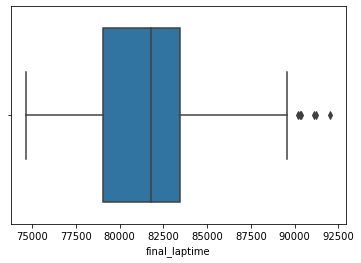

In [71]:
sns.boxplot(qualifying_dataframe_model_montmelo['final_laptime'])

# 4. Creation of the qualifying model

## 4.1 Linear Regression

First we are going to test a simple linear regression and adding variables in order to see if the r2_score it improves or not.

In [72]:
df_linear_regression_quali=pd.DataFrame(columns=['Columns', 'R2_score', 'Mse'])

Those are the variables that we selected for the analysis

In [73]:
numerical= ['avg_position_3_prev_qualis_driver','prev_gap_to_leader_team',
            'avg_3_prev_qualis_position_team','avg_gap_to_leader_3_races_team','precip','temp','wind_speed']
categorical = [ 'constructorName']

In [74]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [75]:
X=qualifying_dataframe_model_montmelo.drop(['final_laptime'],axis=1)
y=qualifying_dataframe_model_montmelo.final_laptime

In [76]:
model = make_pipeline(preprocessor, LinearRegression())

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [78]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['avg_position_3_prev_qualis_driver',
                                                   'prev_gap_to_leader_team',
                                                   'avg_3_prev_qualis_position_team',
                                                   'avg_gap_to_leader_3_races_team',
                                                   'precip', 'temp',
                                                   'wind_speed']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorName'])])),
                ('linearregression', LinearRegression())])

In [79]:
cross_val_score(model, X, y, scoring='r2', cv=5).mean()

-2.5111877354854757

In [80]:
r2_score = cross_val_score(model, X, y, scoring='r2', cv=5).mean()
y_pred = model.predict(X)
mse= mean_squared_error(y,y_pred)
df_linear_regression_quali = df_linear_regression_quali.append({
        'Columns':categorical+numerical,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [81]:
df_linear_regression_quali

,Columns,R2_score,Mse
0,"[constructorName, avg_position_3_prev_qualis_d...",-2.511188,6978878.354233


We see that we select all the variables, the performe of the r2 score is worst than the baseline. So we have to choose carefully the variables.

## 4.2 Decision Tree Regressor

In [82]:
df_dtree_quali = pd.DataFrame(columns=['Columns', 'Best_Paramaters', 'R2_score', 'Mse'])

In [83]:
categorical= ['constructorName']
numerical = ['position_prev_quali_driver','avg_position_3_prev_qualis_driver',
            'prev_quali_gap_to_leader_driver','avg_gap_to_leader_3_qualis_driver','prev_gap_to_leader_team',
'avg_prev_race_position_team','temp','wind_speed','metres'
            ]
target = ['final_laptime']

In [84]:
qualifying_dataframe_model_dt = qualifying_dataframe_model_montmelo[categorical+numerical+target]
X=qualifying_dataframe_model_dt.drop(['final_laptime'],axis=1)
y=qualifying_dataframe_model_dt.final_laptime

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [86]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [87]:
params = {
    'decisiontreeregressor__max_depth':[3,4,5,7,10], #The maximum depth/levels of the tree
    'decisiontreeregressor__min_samples_split':[1,5,10,15,20], #The minimum number of samples required to split an internal node:
    'decisiontreeregressor__min_samples_leaf':[10,15,20,25] #the minimum of samples that should be in the leaf at the base
}

In [88]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('decisiontreeregressor', DecisionTreeRegressor())
])

In [89]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['position_prev_quali_driver',
                                                   'avg_position_3_prev_qualis_driver',
                                                   'prev_quali_gap_to_leader_driver',
                                                   'avg_gap_to_leader_3_qualis_driver',
                                                   'prev_gap_to_leader_team',
                                                   'avg_prev_race_position_team',
                                                   'temp', 'wind_speed',
                                                   'metres']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorName'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [90]:
grid_search_model = GridSearchCV(model, params, cv=5)

In [91]:
grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['position_prev_quali_driver',
                                                                          'avg_position_3_prev_qualis_driver',
                                                                          'prev_quali_gap_to_leader_driver',
                                                                          'avg_gap_to_leader_3_qualis_driver',
                                                                          'prev_gap_to_leader_team',
                                                                          'avg_prev_race_position_team',
                                                                          'temp',
                                                                          'wind_speed',
                                                                          'metres']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['constructorName'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [3, 4, 5, 7, 10],
                         'decisiontreeregressor__min_samples_leaf': [10, 15, 20,
                                                                     25],
                         'decisiontreeregressor__min_samples_split': [1, 5, 10,
                                                                      15, 20]})

In [92]:
best_parameters=grid_search_model.best_params_
r2_score = grid_search_model.best_score_
y_pred = grid_search_model.predict(X)
mse= mean_squared_error(y,y_pred)
df_dtree_quali = df_dtree_quali.append({
        'Columns':categorical+numerical,
        'Best_Paramaters':best_parameters,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [93]:
df_dtree_quali

,Columns,Best_Paramaters,R2_score,Mse
0,"[constructorName, position_prev_quali_driver, ...","{'decisiontreeregressor__max_depth': 7, 'decis...",0.618668,1987093.328139


Here we have evaluated the combination of variables take into account the r2 score and the mean squared error.
We will try another model to see (with the best combination of variables) to see if we have better results or not.

## 4.3 XGB Regressor

In [94]:
df_xgboost_model_quali = pd.DataFrame(columns=['Columns', 'Best_Paramaters', 'R2_score', 'Mse'])

In [95]:
categorical= ['constructorName','driver_fullname']
numerical = ['position_prev_quali_driver','avg_position_3_prev_qualis_driver',
            'prev_quali_gap_to_leader_driver','avg_gap_to_leader_3_qualis_driver','prev_gap_to_leader_team',
'avg_prev_race_position_team','temp','wind_speed','metres'
            ]
target = ['final_laptime']

In [96]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [97]:
qualifying_dataframe_model_dt =qualifying_dataframe_model_montmelo[categorical+numerical+target]
X=qualifying_dataframe_model_dt.drop(['final_laptime'],axis=1)
y=qualifying_dataframe_model_dt.final_laptime

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [99]:
params = {
    'xgbregressor__n_estimators':[50,100,150,200],
    'xgbregressor__max_depth':[3,5,10,15,20],
}

In [100]:
model = make_pipeline(preprocessor, xgb.XGBRegressor())

In [101]:
grid_search_model_quali = GridSearchCV(model, params, cv=5, n_jobs=1,scoring='r2')

In [102]:
grid_search_model_quali.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['position_prev_quali_driver',
                                                                          'avg_position_3_prev_qualis_driver',
                                                                          'prev_quali_gap_to_leader_driver',
                                                                          'avg_gap_to_leader_3_qualis_driver',
                                                                          'prev_gap_to_leader_team',
                                                                          'avg_prev_race_position_team',
                                                                          'temp',
                                                                          'wind_speed',
                                                                          'metre...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=1,
             param_grid={'xgbregressor__max_depth': [3, 5, 10, 15, 20],
                         'xgbregressor__n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [103]:
best_parameters=grid_search_model_quali.best_params_
r2_score = grid_search_model_quali.best_score_
y_pred = grid_search_model_quali.predict(X)
mse= mean_squared_error(y,y_pred)
df_xgboost_model_quali = df_xgboost_model_quali.append({
        'Columns':numerical,
        'Best_Paramaters':best_parameters,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [104]:
df_xgboost_model_quali

,Columns,Best_Paramaters,R2_score,Mse
0,"[position_prev_quali_driver, avg_position_3_pr...","{'xgbregressor__max_depth': 3, 'xgbregressor__...",0.908788,241597.259161


With this model, there are good results but just in case, we will test if there is overffiting or not.

## 4.3.1 Testing overfitting 

I am gonna test if there is overfitting or not, by taking out all the values of the target variable that are lower of the inferior limit or higher of the superior limit of the IQR.

In [105]:
q1 = np.percentile(qualifying_dataframe_model_montmelo.final_laptime, 25)
q3 = np.percentile(qualifying_dataframe_model_montmelo.final_laptime, 75)
IQR = q3 - q1
lInf = q1- 1.5*IQR
lSup = q3 + 1.5*IQR

In [106]:
qualifying_dataframe_model_iqr=qualifying_dataframe_model_montmelo[(qualifying_dataframe_model_montmelo.final_laptime>lInf)&(qualifying_dataframe_model_montmelo.final_laptime<lSup)]

In [107]:
categorical= ['constructorName','driver_fullname']
numerical = ['position_prev_quali_driver','avg_position_3_prev_qualis_driver',
            'prev_quali_gap_to_leader_driver','avg_gap_to_leader_3_qualis_driver','prev_gap_to_leader_team',
'avg_prev_race_position_team','temp','wind_speed','metres'
            ]
target = ['final_laptime']

In [108]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [109]:
qualifying_dataframe_model_dt = qualifying_dataframe_model_iqr[categorical+numerical+target]
X=qualifying_dataframe_model_dt.drop(['final_laptime'],axis=1)
y=qualifying_dataframe_model_dt.final_laptime

In [110]:
params = {
    'xgbregressor__n_estimators':[50,100,150,200],
    'xgbregressor__max_depth':[3,5,10,15,20],
}

In [111]:
model = make_pipeline(preprocessor, xgb.XGBRegressor())

In [112]:
grid_search_model = GridSearchCV(model, params, cv=5, n_jobs=1,scoring='r2')

In [113]:
grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['position_prev_quali_driver',
                                                                          'avg_position_3_prev_qualis_driver',
                                                                          'prev_quali_gap_to_leader_driver',
                                                                          'avg_gap_to_leader_3_qualis_driver',
                                                                          'prev_gap_to_leader_team',
                                                                          'avg_prev_race_position_team',
                                                                          'temp',
                                                                          'wind_speed',
                                                                          'metre...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=1,
             param_grid={'xgbregressor__max_depth': [3, 5, 10, 15, 20],
                         'xgbregressor__n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [114]:
best_parameters=grid_search_model.best_params_
r2_score = grid_search_model.best_score_
y_pred = grid_search_model.predict(X)
mse= mean_squared_error(y,y_pred)
print("r2_Score",r2_score,
     "mse",mse)

r2_Score 0.908787973430756 mse 244821.3668499382


We can see that taking out the outliers, it does not improve the r2 score, therefore there is not overfitting.

# Prediction

With the data that we have, we will predict the laptime on the qualifying session. We will use for the race model.

In [115]:
qualifying_dataframe_model_final = qualifying_dataframe_model_montmelo
X=qualifying_dataframe_model_final
qualifying_dataframe_model_final['laptime_prediction']=grid_search_model_quali.predict(X)
qualifying_dataframe_model_montmelo['rank_position_predicted']=qualifying_dataframe_model_montmelo.groupby(['year'])['laptime_prediction'].rank()

# Part 2- Lap Races

Now we would like to create a model in order to predict the races. In this case, we will predict the race position based on also the results of the qualifying model.

## 1. Creation of the dataframe and data wranggling

The aim with the next actions is to have the information in one table since right now is only in one table.

In [116]:
drivers['driver_fullname'] = drivers['forename']+" "+drivers['surname']

Here we will create the lap times dataframe and joining information with other tables.

In [117]:
lap_times_datafame=lap_times.merge(drivers[['code','driverId','driver_fullname']], on='driverId', how ='left')

In [118]:
lap_times_datafame=lap_times_datafame.merge(races[['raceId','year','round','name','circuitId']],on='raceId', how='left')

Here we want which position it starts the race and the position ended.

In [119]:
lap_times_datafame.rename(columns={'position':'lap_position'},inplace=True)

In [120]:
lap_times_datafame=lap_times_datafame.merge(results[['raceId','grid','statusId','driverId','positionOrder','constructorId']],on=['raceId','driverId'], how='left')

In [121]:
lap_times_datafame=lap_times_datafame.rename(columns={'grid':'GridPosition','positionOrder':'final_position'})

Here we want to know if the driver finished the race.

In [122]:
lap_times_datafame=lap_times_datafame.merge(status, on ='statusId',how='inner')

In [123]:
lap_times_datafame.drop('statusId',axis=1,inplace=True)

In [124]:
lap_times_datafame.rename(columns = {'name':'grand_prix'}, inplace = True)

The goal of this is to have the constructor name for all the laps.

In [125]:
lap_times_datafame = lap_times_datafame.merge(constructors[['constructorId','name']], on='constructorId',how='left')

In [126]:
lap_times_datafame.rename(columns = {'name':'constructorName'}, inplace = True)

Here we want to have the information of the pitstops occurred on the race.

In [127]:
lap_times_datafame = lap_times_datafame.merge(pit_stops[['raceId','driverId','stop','lap','duration']],
                    on=['raceId','driverId','lap'], how='left')

In [128]:
lap_times_datafame.rename(columns = {'stop':'numstops','duration':'pitstopduration',
                                'time':'laptime'}, inplace = True)

Here we want to have the name of the circuit that the race was held.

In [129]:
lap_times_datafame = lap_times_datafame.merge(races.merge(circuits[['circuitId','name']],on='circuitId',how='left')[['raceId','name_y']],on='raceId',how='left')

In [130]:
lap_times_datafame.rename(columns = {'name_y':'circuit'}, inplace = True)

We will analyze the race with miliseconds.

In [131]:
lap_times_datafame.drop('laptime',axis=1,inplace=True)

In [132]:
lap_times_datafame.rename(columns = {'milliseconds':'LapTime'}, inplace = True)

We will transform pitstop duration as a float in order to be treated correctly.

In [133]:
lap_times_datafame['pitstopduration'] =  lap_times_datafame['pitstopduration'].apply(lambda x: float(x) if ':' not in str(x) else float(x.replace(':',',').replace('.','').replace(',','.')))                              

## Dataframe

Now we will create a rank to know the order of the races in order of year and round. So it is easier to order and to create new columns.

In [134]:
lap_times_datafame["rank"] = lap_times_datafame[["year","round"]].apply(tuple,axis=1)\
             .rank(method='dense',ascending=True).astype(int)

In [135]:
lap_times_datafame.sort_values(by=['rank','driver_fullname','lap'],inplace=True)

In [136]:
lap_times_datafame.reset_index(inplace=True)

# 2. Creation of the KPI's

Here we want to calcule the number of times he entered in boxes (ex: to change tyres, complete a penalty...)

In [137]:
lap_times_datafame['boxes']=np.where(lap_times_datafame['pitstopduration']>0,1,0)

In [138]:
lap_times_datafame['num_stops']=lap_times_datafame.groupby(['raceId','driver_fullname'])['boxes'].cumsum()

One of the things that we want to measure is tyre degradation. Since we don't have which tyre are using, we will calculate the standard deviation for every stop.

In [139]:
lap_times_datafame['best_lap_stint']=lap_times_datafame.groupby(['raceId','driver_fullname','num_stops'])['LapTime'].transform('min')

In [140]:
lap_times_datafame['diff_best_lap_stint']=lap_times_datafame['LapTime']-lap_times_datafame['best_lap_stint']

In [141]:
lap_times_datafame['std_stint']=lap_times_datafame.groupby(['raceId','driver_fullname','num_stops'])['LapTime'].transform('std')

Another we want to calculate is the number of positions between laps. Specially, it would be usefull to calculate how many positions are gained in the first lap

In [142]:
lap_times_datafame=lap_times_datafame.sort_values(['rank','driver_fullname','lap'])

In [143]:
lap_times_datafame.loc[(lap_times_datafame.lap==1),'position_gained_first_lap']=lap_times_datafame['lap_position']-lap_times_datafame['GridPosition']

Now let's aggregate the data to not have the information lap by lap.

In [144]:
agg_dict= {'LapTime':['mean','min','sum','std'],'num_stops':'max','diff_best_lap_stint':'mean','position_gained_first_lap':'max',
     'pitstopduration':['mean','sum'],'GridPosition':'max','final_position':'max',
    'position_gained_first_lap':'max','std_stint':'mean','lap':'count'}

In [145]:
lap_time_agg = lap_times_datafame.groupby(['rank','grand_prix','raceId','circuit','round','year','constructorName','driver_fullname','driverId','status']).agg(agg_dict).reset_index()

In [146]:
lap_time_agg.columns = [' '.join(col).strip() for col in lap_time_agg.columns.values]

In [147]:
lap_time_agg = lap_time_agg.rename(columns={'LapTime mean':'Average_LapTime','LapTime std':'std_LapTime',
                               'num_stops max':'Pitstops','diff_best_lap_stint mean':'average_difference_best_lap_of_stint',
                               'pitstopduration mean':'average_pit_stop_duration', 
                                'pitstopduration sum': 'sum_pit_stop_duration',
                               'LapTime min':'fastest_lap',
                                'final_position max':'final_position',
                                'position_gained_first_lap max':'position_gained_first_lap',
                                'GridPosition max':'GridPosition','std_stint mean':'mean_std_lap_times_stint',
                                           'lap count':'number_laps','LapTime sum':'Total_time','Laptime std':'Laptime_std'})

In [148]:
lap_time_agg=lap_time_agg.sort_values(by=['year','round','driver_fullname'])

I want to add the time gap compareda to the the leader. For the ones that have been overlapped, we will try to calculate

In [149]:
lap_time_agg=lap_time_agg.merge(results[['driverId','raceId','milliseconds']],on=['raceId','driverId'],how='inner').rename({'milisecons':'total_time'},axis=1)

In [150]:
lap_time_agg['laps_to_complete']=lap_time_agg.groupby(['year','circuit'])['number_laps'].transform('max')

In [151]:
lap_time_agg['laps_remaining']=lap_time_agg['laps_to_complete']-lap_time_agg['number_laps']

In [152]:
lap_time_agg.reset_index(inplace=True)

Now we would like to calculate to the group the finish status in order to make it easier to analyze. 

In [153]:
f2.status_cleaning(lap_time_agg)

In [154]:
one_hot = pd.get_dummies(lap_time_agg['clean_status'])
lap_time_agg = lap_time_agg.join(one_hot)

In [155]:
lap_time_agg.drop(columns=['clean_status','status','laps_to_complete'],axis=1,inplace=True)

Now let's try to calculate some kpis in order to predict the race.

# Driver's KPI's

As we did previously, we want to calculate averages of the 3 previous races.  The idea will be to predict if he wins or not based on past data.

Here we want to have the grid positions of previous races. The idea is to predict the target variable with past data.

In [156]:
lap_time_agg['previous_race_GridPosition_driver']=lap_time_agg.groupby(['driver_fullname'])['GridPosition'].shift(1)
lap_time_agg['previous_2race_GridPosition_driver']=lap_time_agg.groupby(['driver_fullname'])['GridPosition'].shift(2)
lap_time_agg['previous_3race_GridPosition_driver']=lap_time_agg.groupby(['driver_fullname'])['GridPosition'].shift(3)
lap_time_agg['average_GridPosition_3_prev_races_driver']=(lap_time_agg['previous_race_GridPosition_driver']+lap_time_agg['previous_2race_GridPosition_driver']
                                                  +lap_time_agg['previous_3race_GridPosition_driver'])/3

In [157]:
lap_time_agg.drop(columns=['previous_2race_GridPosition_driver','previous_3race_GridPosition_driver'],axis=1,inplace=True)

The idea of this is to calculate the lowest and the highest laptime per driver(with the assumption that follows a normal distribution) based on the laptime that we have. The idea is to know how quick is the driver.

In [158]:
lap_time_agg['max_lap']=lap_time_agg['std_LapTime']*2+lap_time_agg['Average_LapTime']
lap_time_agg['min_lap']=lap_time_agg['Average_LapTime']-lap_time_agg['std_LapTime']*2

We want to calculate the average laptime per driver of the previous race.

In [159]:
lap_time_agg['previous_avergaelaptime_driver']=lap_time_agg.groupby(['driver_fullname'])['Average_LapTime'].shift(1)

In [160]:
lap_time_agg['previous_avergaemaxlaptime_driver']=lap_time_agg.groupby(['driver_fullname'])['max_lap'].shift(1)
lap_time_agg['previous_avergaeminlaptime_driver']=lap_time_agg.groupby(['driver_fullname'])['min_lap'].shift(1)

In [161]:
lap_time_agg['prev_fastest_lap_circuit']=lap_time_agg.groupby(['driver_fullname','circuit'])['fastest_lap'].shift(1)

Previous races trajectory car-driver

In [162]:
lap_time_agg['grid_position_driver_with_same_car']=lap_time_agg.groupby(['constructorName','driverId'])['previous_race_GridPosition_driver'].cumsum()/lap_time_agg.groupby(['constructorName','driverId'])['previous_race_GridPosition_driver'].cumcount()

Position Gained First Lap in previous races

In [163]:
lap_time_agg['previous_race_position_gained_first_lap_driver']=lap_time_agg.groupby(['driver_fullname'])['position_gained_first_lap'].shift(1)
lap_time_agg['previous_2race_position_gained_first_lap_driver']=lap_time_agg.groupby(['driver_fullname'])['position_gained_first_lap'].shift(2)
lap_time_agg['previous_3race_position_gained_first_lap_driver']=lap_time_agg.groupby(['driver_fullname'])['position_gained_first_lap'].shift(3)
lap_time_agg['average_position_gained_first_lap_3_prev_races_driver']=(lap_time_agg['previous_race_position_gained_first_lap_driver']+lap_time_agg['previous_2race_position_gained_first_lap_driver']
                                                  +lap_time_agg['previous_3race_position_gained_first_lap_driver'])/3

In [164]:
lap_time_agg.drop(columns=['previous_2race_position_gained_first_lap_driver','previous_3race_position_gained_first_lap_driver'],axis=1,inplace=True)

Standard deviation of lap times per stint in previous races

In [165]:
lap_time_agg['previous_race_std_lap_times_stint_driver']=lap_time_agg.groupby(['driver_fullname'])['mean_std_lap_times_stint'].shift(1)
lap_time_agg['previous_2race_std_lap_times_stint_driver']=lap_time_agg.groupby(['driver_fullname'])['mean_std_lap_times_stint'].shift(2)
lap_time_agg['previous_3race_std_lap_times_stint_driver']=lap_time_agg.groupby(['driver_fullname'])['mean_std_lap_times_stint'].shift(3)
lap_time_agg['average_std_lap_times_3_prev_races_driver']=(lap_time_agg['previous_race_std_lap_times_stint_driver']+lap_time_agg['previous_2race_std_lap_times_stint_driver']
                                                  +lap_time_agg['previous_3race_std_lap_times_stint_driver'])/3

In [166]:
lap_time_agg.drop(columns=['previous_2race_std_lap_times_stint_driver','previous_3race_std_lap_times_stint_driver'],axis=1,inplace=True)

Average of pitstop duration of previous races.

In [167]:
lap_time_agg['previous_race_avg_pistopduration_driver']=lap_time_agg.groupby(['driver_fullname'])['average_pit_stop_duration'].shift(1)
lap_time_agg['previous_2race_avg_pistopduration_driver']=lap_time_agg.groupby(['driver_fullname'])['average_pit_stop_duration'].shift(2)
lap_time_agg['previous_3race_avg_pistopduration_driver']=lap_time_agg.groupby(['driver_fullname'])['average_pit_stop_duration'].shift(3)
lap_time_agg['average_avg_pistopduration_3_prev_races_driver']=(lap_time_agg['previous_race_avg_pistopduration_driver']+lap_time_agg['previous_2race_avg_pistopduration_driver']
                                                  +lap_time_agg['previous_3race_avg_pistopduration_driver'])/3

In [168]:
lap_time_agg.drop(columns=['previous_2race_avg_pistopduration_driver','previous_3race_avg_pistopduration_driver'],axis=1,inplace=True)

Previous final position in race

In [169]:
lap_time_agg['previous_finalposition_race_driver']=lap_time_agg.groupby(['driver_fullname'])['final_position'].shift(1)
lap_time_agg['previous_finalposition_2_race_driver']=lap_time_agg.groupby(['driver_fullname'])['final_position'].shift(2)
lap_time_agg['previous_finalposition_3_race_driver']=lap_time_agg.groupby(['driver_fullname'])['final_position'].shift(3)
lap_time_agg['average_finalposition_3_prev_races_driver']=(lap_time_agg['previous_finalposition_race_driver']+lap_time_agg['previous_finalposition_2_race_driver']
                                                  +lap_time_agg['previous_finalposition_3_race_driver'])/3

In [170]:
lap_time_agg.drop(columns=['previous_finalposition_2_race_driver','previous_finalposition_3_race_driver'],axis=1,inplace=True)

Traj in the same car

In [171]:
lap_time_agg['grid_position_driver_with_same_car']=lap_time_agg.groupby(['constructorName','driverId'])['previous_finalposition_race_driver'].cumsum()/lap_time_agg.groupby(['constructorName','driverId'])['previous_finalposition_race_driver'].cumcount()

Previous race same circuit

In [172]:
lap_time_agg['previous_finalposition_race_driver']=lap_time_agg.groupby(['driver_fullname','circuit'])['final_position'].shift(1)

Now let's calculate the percentatge of driver of finshing the race per previous races

In [173]:
lap_time_agg['previous_race_finished_driver']=lap_time_agg.groupby(['driver_fullname'])['Finished'].shift(1)
lap_time_agg['previous_2race_finished_driver']=lap_time_agg.groupby(['driver_fullname'])['Finished'].shift(2)
lap_time_agg['previous_3race_finished_driver']=lap_time_agg.groupby(['driver_fullname'])['Finished'].shift(3)
lap_time_agg['average_finished_3_prev_races_driver']=(lap_time_agg['previous_race_finished_driver']+lap_time_agg['previous_2race_finished_driver']+lap_time_agg['previous_3race_finished_driver'])/3

In [174]:
lap_time_agg.drop(['previous_2race_finished_driver','previous_3race_finished_driver'],axis=1,inplace=True)

Now let's calculate the percentatge of driver if he was overlapped or not

In [175]:
lap_time_agg['previous_race_overlapped_driver']=lap_time_agg.groupby(['driver_fullname'])['Overlap'].shift(1)
lap_time_agg['previous_2race_overlapped_driver']=lap_time_agg.groupby(['driver_fullname'])['Overlap'].shift(2)
lap_time_agg['previous_3race_overlapped_driver']=lap_time_agg.groupby(['driver_fullname'])['Overlap'].shift(3)
lap_time_agg['average_overlapped_3_prev_races_driver']=(lap_time_agg['previous_race_overlapped_driver']+lap_time_agg['previous_2race_overlapped_driver']+lap_time_agg['previous_3race_overlapped_driver'])/3

In [176]:
lap_time_agg.drop(['previous_2race_overlapped_driver','previous_2race_overlapped_driver'],axis=1,inplace=True)

Now let's calculate the percentahe if there was an accident in the car

In [177]:
lap_time_agg['previous_race_accident_driver']=lap_time_agg.groupby(['driver_fullname'])['Accident'].shift(1)
lap_time_agg['previous_2race_accident_driver']=lap_time_agg.groupby(['driver_fullname'])['Accident'].shift(2)
lap_time_agg['previous_3race_accident_driver']=lap_time_agg.groupby(['driver_fullname'])['Accident'].shift(3)
lap_time_agg['average_accident_3_prev_races_driver']=(lap_time_agg['previous_race_accident_driver']+lap_time_agg['previous_2race_accident_driver']+lap_time_agg['previous_3race_accident_driver'])/3

Also let's calculate in the trajectory of the driver the percentage of accidents he had.

In [178]:
lap_time_agg['avg_accident_driv_traj']=lap_time_agg.groupby('driver_fullname')['previous_race_accident_driver'].cumsum()/(lap_time_agg.groupby('driver_fullname')['previous_race_accident_driver'].cumcount())

Also let's calculate if he beat the teammate or not, it's the one that you can compare easier because it has equal machinery.

In [179]:
lap_time_agg["best_position_race_team"]=lap_time_agg.groupby(['rank','constructorName'])['final_position'].transform('min')

In [180]:
lap_time_agg["beat_teammate_race"]=np.where(lap_time_agg["best_position_race_team"]==lap_time_agg["final_position"],1,0)

In [181]:
lap_time_agg["prev_beat_teammate_race"]=lap_time_agg.groupby(['driver_fullname'])['beat_teammate_race'].shift(1)
lap_time_agg["prev_beat_teammate_2race"]=lap_time_agg.groupby(['driver_fullname'])['beat_teammate_race'].shift(2)
lap_time_agg["prev_beat_teammate_3race"]=lap_time_agg.groupby(['driver_fullname'])['beat_teammate_race'].shift(3)

In [182]:
lap_time_agg['average_accident_3_prev_races']=(lap_time_agg["prev_beat_teammate_race"]+lap_time_agg["prev_beat_teammate_2race"]+lap_time_agg["prev_beat_teammate_3race"])/3

## Car's Kpis

Let's calculate the average position per team

In [183]:
lap_time_agg["worst_position_race_team"]=lap_time_agg.groupby(['rank','constructorName'])['final_position'].transform('max')

In [184]:
lap_time_agg['avg_position_race_team']=(lap_time_agg["worst_position_race_team"]+lap_time_agg["best_position_race_team"])/2

In [185]:
lap_time_agg['best_GridPosiition_qualifyig_team']=lap_time_agg.groupby(['constructorName','rank'])['GridPosition'].transform('min')
lap_time_agg['worst_GridPosiition_qualifyig_team']=lap_time_agg.groupby(['constructorName','rank'])['GridPosition'].transform('max')

In [186]:
lap_time_agg['avg_GridPosiition_qualifyig_team']=(lap_time_agg['worst_GridPosiition_qualifyig_team']+lap_time_agg['best_GridPosiition_qualifyig_team'])/2

Here we want to calculate the percentage of ending the race in teams level. Also we want to calculate the percentage in the past of having a problem in the car, and therefore not finsih the race because of that.

In [187]:
lap_time_agg['driver1_finished_race_team']=lap_time_agg.groupby(['constructorName','rank'])['Finished'].transform('min')
lap_time_agg['driver2_finished_race_team']=lap_time_agg.groupby(['constructorName','rank'])['Finished'].transform('max')
lap_time_agg['percentage_drivers_finish_race_team']=(lap_time_agg['driver1_finished_race_team']+lap_time_agg['driver2_finished_race_team'])/2

In [188]:
lap_time_agg['driver1_carproblem_race_team']=lap_time_agg.groupby(['constructorName','rank'])['Car Problem'].transform('min')
lap_time_agg['driver2_carproblem_race_team']=lap_time_agg.groupby(['constructorName','rank'])['Car Problem'].transform('max')
lap_time_agg['percentage_drivers_carproblem_race_team']=(lap_time_agg['driver1_carproblem_race_team']+lap_time_agg['driver2_carproblem_race_team'])/2

In [189]:
lap_time_agg['driver1_sumpitstopduration_race_team']=lap_time_agg.groupby(['constructorName','rank'])['sum_pit_stop_duration'].transform('min')
lap_time_agg['driver2_sumpitstopduration_race_team']=lap_time_agg.groupby(['constructorName','rank'])['sum_pit_stop_duration'].transform('max')
lap_time_agg['average_sumpitstopduration_driver_team']=(lap_time_agg['driver2_sumpitstopduration_race_team']+lap_time_agg['driver1_sumpitstopduration_race_team'])/2

Also we want to calculate the percentage of finishing the race (without being overlapped) in team's level

In [190]:
lap_time_agg_team=lap_time_agg[['rank','constructorName','year','avg_position_race_team',"avg_GridPosiition_qualifyig_team",
                                'percentage_drivers_finish_race_team',
                               'percentage_drivers_carproblem_race_team',
                               'average_sumpitstopduration_driver_team']].drop_duplicates()

Let's add the average position of race cosnidering the two drivers of the team.

In [191]:
lap_time_agg_team['prev_avg_position_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_position_race_team'].shift(1)
lap_time_agg_team['2prev_avg_position_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_position_race_team'].shift(2)
lap_time_agg_team['3prev_avg_position_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_position_race_team'].shift(3)

In [192]:
lap_time_agg_team['average_race_position_team_3_prev_races']=(lap_time_agg_team['prev_avg_position_race_team']+lap_time_agg_team['2prev_avg_position_race_team']+lap_time_agg_team['3prev_avg_position_race_team'])/3

Here we want to calculate the average position per previous races.

Here we want to calculate the average position per team in the starting grid and calculate for previous races.

In [193]:
lap_time_agg_team['prev_avg_GridPosition_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_GridPosiition_qualifyig_team'].shift(1)
lap_time_agg_team['2prev_avg_GridPosition_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_GridPosiition_qualifyig_team'].shift(2)
lap_time_agg_team['3prev_avg_GridPosition_race_team']=lap_time_agg_team.groupby(['constructorName'])['avg_GridPosiition_qualifyig_team'].shift(3)

In [194]:
lap_time_agg_team['average_GridPosition_team_3_prev_races']=(lap_time_agg_team['prev_avg_GridPosition_race_team']+lap_time_agg_team['2prev_avg_GridPosition_race_team']+lap_time_agg_team['3prev_avg_GridPosition_race_team'])/3

We want to calculate the average percentage of car's problem during previous races

In [195]:
lap_time_agg_team['prev_race_car_problem_race_team']=lap_time_agg_team.groupby(['constructorName'])['percentage_drivers_carproblem_race_team'].shift(1)
lap_time_agg_team['2prev_race_car_problem_race_team']=lap_time_agg_team.groupby(['constructorName'])['percentage_drivers_carproblem_race_team'].shift(2)
lap_time_agg_team['3prev_race_car_problem_race_team']=lap_time_agg_team.groupby(['constructorName'])['percentage_drivers_carproblem_race_team'].shift(3)
lap_time_agg_team['avg_3prev_race_car_problem_race_team']=(lap_time_agg_team['prev_race_car_problem_race_team']+lap_time_agg_team['2prev_race_car_problem_race_team']
                                                          +lap_time_agg_team['3prev_race_car_problem_race_team'])/3

We want to put the average of sum of pitstop duration per driver and per team for previous races

In [196]:
lap_time_agg_team['prev_average_sumpitstopduration_driver_team']=lap_time_agg_team.groupby(['constructorName'])['average_sumpitstopduration_driver_team'].shift(1)
lap_time_agg_team['2prev_average_sumpitstopduration_driver_team']=lap_time_agg_team.groupby(['constructorName'])['average_sumpitstopduration_driver_team'].shift(2)
lap_time_agg_team['3prev_average_sumpitstopduration_driver_team']=lap_time_agg_team.groupby(['constructorName'])['average_sumpitstopduration_driver_team'].shift(3)
lap_time_agg_team['avg_3_average_sumpitstopduration_driver_team']=(lap_time_agg_team['prev_average_sumpitstopduration_driver_team']+lap_time_agg_team['2prev_average_sumpitstopduration_driver_team']
                                                          +lap_time_agg_team['3prev_average_sumpitstopduration_driver_team'])/3

In [197]:
lap_time_agg_team.drop(columns=['2prev_avg_position_race_team','3prev_avg_position_race_team','2prev_avg_GridPosition_race_team',
       '3prev_avg_GridPosition_race_team','2prev_race_car_problem_race_team',
       '3prev_race_car_problem_race_team','avg_position_race_team','avg_GridPosiition_qualifyig_team',
                               'percentage_drivers_finish_race_team','percentage_drivers_carproblem_race_team',
                               '2prev_average_sumpitstopduration_driver_team','3prev_average_sumpitstopduration_driver_team',
                               'average_sumpitstopduration_driver_team'],
                      inplace=True)

Now let's do a join with the previous data aggregated by team.

In [198]:
lap_time_model=lap_time_agg.merge(lap_time_agg_team, on=['year','rank','constructorName'],how='inner')

# Montmelo database

Now we are going to filter only Montmelo

In [199]:
lap_time_model_montmelo=lap_time_model[(lap_time_model.circuit=='Circuit de Barcelona-Catalunya')
                                       &(lap_time_model.year>2005)].sort_values(by=['rank','constructorName',
                                                                                            'driver_fullname'])

In [200]:
lap_time_model_montmelo.drop(['fastest_lap', 'Pitstops',
       'average_difference_best_lap_of_stint', 'position_gained_first_lap',
       'average_pit_stop_duration', 'sum_pit_stop_duration','mean_std_lap_times_stint', 'Accident', 'Car Problem',
       'Disqualified/Not qualified', 'Driver issue', 'Finished', 'Overlap',
       'Retired', 'Tyre Problem','previous_2race_accident_driver',
       'previous_3race_accident_driver','best_GridPosiition_qualifyig_team',
       'worst_GridPosiition_qualifyig_team','worst_position_race_team', 'avg_position_race_team'
       ,'best_position_race_team','beat_teammate_race','prev_beat_teammate_2race', 'prev_beat_teammate_3race',
        'avg_GridPosiition_qualifyig_team','driver1_finished_race_team', 'driver2_finished_race_team',
       'percentage_drivers_finish_race_team', 'driver1_carproblem_race_team',
       'driver2_carproblem_race_team',
       'percentage_drivers_carproblem_race_team',
       'driver1_sumpitstopduration_race_team',
       'driver2_sumpitstopduration_race_team',
       'average_sumpitstopduration_driver_team'],axis=1,inplace=True)

We will filter above 2010 since there were no data of pitstop duration

In [201]:
lap_time_model_montmelo=lap_time_model_montmelo[lap_time_model_montmelo.year>2010].dropna()

Now let's do a join with the weather

In [202]:
lap_time_model_montmelo=lap_time_model_montmelo.merge(race_weather,on=['year'],how='inner')

In [203]:
lap_time_model_montmelo=lap_time_model_montmelo.merge(qualifying_dataframe_model_final[['year', 'circuit', 'driver_fullname', 'constructorName',
       'prev_gap_to_leader_team', 'avg_gap_to_leader_3_races_team',
       'avg_percentaje_beat_teammate_quali_driver', 'poles_prev_quali_driver',
       'q2_previous_qualifying_driver', 'q3_previous_qualifying_driver',
       'q2_percentage_driver', 'q3_percentage_driver','laptime_prediction',
       'rank_position_predicted',]],on=['circuit','constructorName','driver_fullname','year'],how='inner')

In [204]:
lap_time_model_montmelo.drop(['index', 'rank', 'grand_prix', 'circuit', 'round', 'year','Unnamed: 0', 'date',
       'start_time', 'lat', 'lng', 'next_time','GridPosition', 'temp', 'precip', 'wind_speed',
                             'Average_LapTime', 'Total_time', 'std_LapTime',
       'number_laps', 'milliseconds', 'laps_remaining','max_lap', 'min_lap','grid_position_driver_with_same_car',
                             'driverId','raceId'],axis=1,inplace=True)

# 3.Exploratoty data Analysys

We calculate the linear correlation with the target variable.

In [205]:
lap_time_model_montmelo.corr()[['final_position']]

,final_position
final_position,1.000000
previous_race_GridPosition_driver,0.660747
average_GridPosition_3_prev_races_driver,0.688013
previous_avergaelaptime_driver,0.073665
previous_avergaemaxlaptime_driver,-0.005383
previous_avergaeminlaptime_driver,0.118145
prev_fastest_lap_circuit,0.050534
previous_race_position_gained_first_lap_driver,-0.101728
average_position_gained_first_lap_3_prev_races_driver,-0.127077
previous_race_std_lap_times_stint_driver,-0.049710


## 4.1 Linear Regression

First we are going to test a simple logistic regression and adding variables in order to see if the r2_score it improves or not. We will need to do oversampling on the winning part.

In [206]:
df_linear_regression_race=pd.DataFrame(columns=['Columns', 'R2_score', 'Mse'])

Those are the variables that we selected for the analysis

In [207]:
numerical= [
       'previous_race_GridPosition_driver',
       'average_GridPosition_3_prev_races_driver',
       'previous_avergaelaptime_driver', 'previous_avergaemaxlaptime_driver',
       'previous_avergaeminlaptime_driver', 'prev_fastest_lap_circuit',
       'previous_race_position_gained_first_lap_driver',
       'average_position_gained_first_lap_3_prev_races_driver',
       'previous_race_std_lap_times_stint_driver',
       'average_std_lap_times_3_prev_races_driver',
       'previous_race_avg_pistopduration_driver',
       'average_avg_pistopduration_3_prev_races_driver',
       'previous_finalposition_race_driver',
       'average_finalposition_3_prev_races_driver',
       'previous_race_finished_driver', 'average_finished_3_prev_races_driver',
       'previous_race_overlapped_driver', 'previous_3race_overlapped_driver',
       'average_overlapped_3_prev_races_driver',
       'previous_race_accident_driver', 'average_accident_3_prev_races_driver',
       'avg_accident_driv_traj', 'prev_beat_teammate_race',
       'average_accident_3_prev_races', 'prev_avg_position_race_team',
       'average_race_position_team_3_prev_races',
       'prev_avg_GridPosition_race_team',
       'average_GridPosition_team_3_prev_races',
       'prev_race_car_problem_race_team',
       'avg_3prev_race_car_problem_race_team',
       'prev_average_sumpitstopduration_driver_team',
       'avg_3_average_sumpitstopduration_driver_team',
       'prev_gap_to_leader_team', 'avg_gap_to_leader_3_races_team',
       'avg_percentaje_beat_teammate_quali_driver', 'poles_prev_quali_driver',
       'q2_previous_qualifying_driver', 'q3_previous_qualifying_driver',
       'q2_percentage_driver', 'q3_percentage_driver', 'laptime_prediction',
       'rank_position_predicted']
categorical = ['constructorName', 'driver_fullname']

In [208]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [209]:
X=lap_time_model_montmelo.drop(['final_position'],axis=1)
y=lap_time_model_montmelo.final_position

In [210]:
model = make_pipeline(preprocessor,LinearRegression())

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [212]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['previous_race_GridPosition_driver',
                                                   'average_GridPosition_3_prev_races_driver',
                                                   'previous_avergaelaptime_driver',
                                                   'previous_avergaemaxlaptime_driver',
                                                   'previous_avergaeminlaptime_driver',
                                                   'prev_fastest_lap_circuit',
                                                   'previous_race_position_gained_fir...
                                                   'prev_avg_position_race_team',
                                                   'average_race_position_team_3_prev_races',
                                                   'prev_avg_GridPosition_race_team',
                                                   'average_GridPosition_team_3_prev_races',
                                                   'prev_race_car_problem_race_team',
                                                   'avg_3prev_race_car_problem_race_team', ...]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorName',
                                                   'driver_fullname'])])),
                ('linearregression', LinearRegression())])

In [213]:
cross_val_score(model, X, y, scoring='r2', cv=5).mean()

-2.506807913577843e+24

In [214]:
r2_score = cross_val_score(model, X, y, scoring='r2', cv=5).mean()
y_pred = model.predict(X)
mse= mean_squared_error(y,y_pred)
df_linear_regression_race = df_linear_regression_race.append({
        'Columns':categorical+numerical,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [215]:
df_linear_regression_race

,Columns,R2_score,Mse
0,"[constructorName, driver_fullname, previous_ra...",-2506807913577842779095040.0,148403630289161056.0


We see that we select all the variables, the performe of the r2 score is worst than the baseline. So we have to choose carefully the variables.

## 4.2 Decision Tree Regressor

In [216]:
df_dtree_model_race = pd.DataFrame(columns=['Columns', 'Best_Paramaters', 'R2_score', 'Mse'])

In [217]:
categorical= ['constructorName']
numerical = ['rank_position_predicted','q3_previous_qualifying_driver','q2_previous_qualifying_driver',
            'avg_3_average_sumpitstopduration_driver_team','average_finished_3_prev_races_driver',
            'previous_race_GridPosition_driver','prev_gap_to_leader_team']
target = ['final_position']

In [218]:
lap_time_model_montmelo_dt = lap_time_model_montmelo[categorical+numerical+target]
X=lap_time_model_montmelo_dt.drop(['final_position'],axis=1)
y=lap_time_model_montmelo_dt.final_position

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [220]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [221]:
params = {
    'decisiontreeregressor__max_depth':[2,3,4,5,7,10], #The maximum depth/levels of the tree
    'decisiontreeregressor__min_samples_split':[1,2,3,4,5,10,15,20], #The minimum number of samples required to split an internal node:
    'decisiontreeregressor__min_samples_leaf':[5.710,15,20,25] #the minimum of samples that should be in the leaf at the base
}

In [222]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('decisiontreeregressor', DecisionTreeRegressor())
])

In [223]:

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['rank_position_predicted',
                                                   'q3_previous_qualifying_driver',
                                                   'q2_previous_qualifying_driver',
                                                   'avg_3_average_sumpitstopduration_driver_team',
                                                   'average_finished_3_prev_races_driver',
                                                   'previous_race_GridPosition_driver',
                                                   'prev_gap_to_leader_team']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorName'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [224]:
grid_search_model = GridSearchCV(model, params, cv=5)

In [225]:
grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['rank_position_predicted',
                                                                          'q3_previous_qualifying_driver',
                                                                          'q2_previous_qualifying_driver',
                                                                          'avg_3_average_sumpitstopduration_driver_team',
                                                                          'average_finished_3_prev_races_driver',
                                                                          'previous_race_GridPosition_driver',
                                                                          'prev_gap_to_leader_team']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['constructorName'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [2, 3, 4, 5, 7,
                                                              10],
                         'decisiontreeregressor__min_samples_leaf': [5.71, 15,
                                                                     20, 25],
                         'decisiontreeregressor__min_samples_split': [1, 2, 3,
                                                                      4, 5, 10,
                                                                      15, 20]})

In [226]:
best_parameters=grid_search_model.best_params_
r2_score = grid_search_model.best_score_
y_pred = grid_search_model.predict(X)
mse= mean_squared_error(y,y_pred)
df_dtree_model_race = df_dtree_model_race.append({
        'Columns':categorical+numerical,
        'Best_Paramaters':best_parameters,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [227]:
df_dtree_model_race

,Columns,Best_Paramaters,R2_score,Mse
0,"[constructorName, rank_position_predicted, q3_...","{'decisiontreeregressor__max_depth': 2, 'decis...",0.553645,19.874507


## 4.3 XGB Regressor

In [228]:
df_xgboost_race = pd.DataFrame(columns=['Columns', 'Best_Paramaters', 'R2_score', 'Mse'])

In [229]:
categorical= ['constructorName']
numerical = ['rank_position_predicted','q3_previous_qualifying_driver','poles_prev_quali_driver','previous_finalposition_race_driver']
target = ['final_position']

In [230]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [231]:
lap_time_model_montmelo_dt = lap_time_model_montmelo[categorical+numerical+target]
X=lap_time_model_montmelo_dt.drop(['final_position'],axis=1)
y=lap_time_model_montmelo_dt.final_position

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [233]:
params = {
    'xgbregressor__n_estimators':[25,50,100,150,200],
    'xgbregressor__max_depth':[1,2,3,5,10,15,20],
    'xgbregressor__learning_rate': [0.1, 0.01, 0.001],
    'xgbregressor__min_child_weight': [1, 3, 5],
    'xgbregressor__subsample': [0.8, 0.9, 1.0]
}

In [234]:
model = make_pipeline(preprocessor, xgb.XGBRegressor(random_state=33))

In [235]:
grid_search_model_race = GridSearchCV(model, params, cv=5, n_jobs=1,scoring='r2')

In [236]:
grid_search_model_race.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['rank_position_predicted',
                                                                          'q3_previous_qualifying_driver',
                                                                          'poles_prev_quali_driver',
                                                                          'previous_finalposition_race_driver']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['constructorName'])])),
                                       ('xgbregressor...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=33, ...))]),
             n_jobs=1,
             param_grid={'xgbregressor__learning_rate': [0.1, 0.01, 0.001],
                         'xgbregressor__max_depth': [1, 2, 3, 5, 10, 15, 20],
                         'xgbregressor__min_child_weight': [1, 3, 5],
                         'xgbregressor__n_estimators': [25, 50, 100, 150, 200],
                         'xgbregressor__subsample': [0.8, 0.9, 1.0]},
             scoring='r2')

In [237]:
best_parameters_race=grid_search_model_race.best_estimator_
r2_score = grid_search_model_race.best_score_
y_pred = grid_search_model_race.predict(X)
best_model_race= xgb.XGBRegressor(**grid_search_model_race.best_params_)
mse= mean_squared_error(y,y_pred)
df_xgboost_race  = df_xgboost_race.append({
        'Columns':categorical+numerical,
        'Best_Paramaters':best_parameters,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [238]:
df_xgboost_race

,Columns,Best_Paramaters,R2_score,Mse
0,"[constructorName, rank_position_predicted, q3_...","{'decisiontreeregressor__max_depth': 2, 'decis...",0.60417,16.529477


# Random Forest Regressor

In [239]:
df_rforest_race = pd.DataFrame(columns=['Columns', 'Best_Paramaters', 'R2_score', 'Mse'])

In [240]:
categorical= ['constructorName']
numerical = ['rank_position_predicted','q3_previous_qualifying_driver','poles_prev_quali_driver','previous_finalposition_race_driver']
target = ['final_position']

In [241]:
preprocessor = make_column_transformer(
  (StandardScaler(), numerical),
  (OneHotEncoder(handle_unknown='ignore'), categorical))

In [242]:
lap_time_model_montmelo_dt = lap_time_model_montmelo[categorical+numerical+target]
X=lap_time_model_montmelo_dt.drop(['final_position'],axis=1)
y=lap_time_model_montmelo_dt.final_position

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [244]:
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [10,15, 20, 30]
}

In [245]:
model = make_pipeline(preprocessor, RandomForestRegressor(random_state=33))

In [246]:
grid_search_model = GridSearchCV(model, param_grid, cv=5, n_jobs=1,scoring='r2')

In [247]:
grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['rank_position_predicted',
                                                                          'q3_previous_qualifying_driver',
                                                                          'poles_prev_quali_driver',
                                                                          'previous_finalposition_race_driver']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['constructorName'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=33))]),
             n_jobs=1,
             param_grid={'randomforestregressor__max_depth': [10, 15, 20, 30],
                         'randomforestregressor__n_estimators': [100, 200,
                                                                 300]},
             scoring='r2')

In [248]:
best_parameters=grid_search_model.best_params_
r2_score = grid_search_model.best_score_
y_pred = grid_search_model.predict(X)
mse= mean_squared_error(y,y_pred)
df_rforest_race  = df_rforest_race.append({
        'Columns':categorical+numerical,
        'Best_Paramaters':best_parameters,
        'R2_score':r2_score,
        'Mse':mse
    },ignore_index=True)

In [249]:
df_rforest_race

,Columns,Best_Paramaters,R2_score,Mse
0,"[constructorName, rank_position_predicted, q3_...","{'randomforestregressor__max_depth': 20, 'rand...",0.569359,12.602614


Finally we arrived to the conclusion that the best model, in terms of R2 Score is the XGB Regressor.

# Prediction for 2023

### 1.1 Qualifying 2023

1. In the initial database, we do not have the data for the 3 occurred in 2023. We have uploaded the missing information on a csv a now we will transform in order to do the join correctly.

In [250]:
qualifying_2023['final_laptime']=np.where(qualifying_2023['q3']>0,qualifying_2023['q3'],np.where(
qualifying_2023['q2']>0,qualifying_2023['q2'],qualifying_2023['q1']))
qualifying_2023['quickest_lap']=qualifying_2023.groupby('round')['final_laptime'].transform('min')
qualifying_2023['gap_to_leader']=qualifying_2023['final_laptime']-qualifying_2023['quickest_lap']

In [251]:
qualifying_2023['gap_to_leader'].fillna(1982,inplace=True)

In [252]:
qualifying_2023.sort_values(by=['round'],inplace=True)

Prev gap to leader quali driver

In [253]:
categorical= ['constructorName','driver_fullname']
numerical = ['position_prev_quali_driver','avg_position_3_prev_qualis_driver',
            'prev_quali_gap_to_leader_driver','avg_gap_to_leader_3_qualis_driver','prev_gap_to_leader_team',
'avg_prev_race_position_team']

In [254]:
qualifying_2023['worst_position_team']=qualifying_2023.groupby('driver_fullname')['position_race'].transform('max')
qualifying_2023['best_position_team']=qualifying_2023.groupby('driver_fullname')['position_race'].transform('min')
qualifying_2023['avg_race_position_team']=(qualifying_2023['worst_position_team']+qualifying_2023['best_position_team'])/2

Of these three races we want to have the data aggregated per driver

In [255]:
aggreg_dict= {'position_quali':'mean',"gap_to_leader":'mean'}            
qualifying_2023_agg_driv = qualifying_2023.groupby(['driver_fullname']).agg(aggreg_dict).reset_index()
qualifying_2023_agg_driv.rename({'position_quali':'avg_position_3_prev_qualis_driver',"gap_to_leader":'avg_gap_to_leader_3_qualis_driver'},axis=1,inplace=True)

In [256]:
qualifying_2023['gap_to_leader_team']=qualifying_2023.groupby(['constructorName','round'])['gap_to_leader'].transform('min')

In [257]:
qualifying_2023_pred=qualifying_2023_agg_driv.merge(qualifying_2023[qualifying_2023.circuit=='Albert Park Grand Prix Circuit'][['driver_fullname',
                                                                                                                          'constructorName','position_quali','gap_to_leader',"avg_race_position_team","gap_to_leader_team"]],on='driver_fullname',how='inner')

In [258]:
qualifying_2023_pred.rename({"position_quali":"position_prev_quali_driver",'gap_to_leader':"prev_quali_gap_to_leader_driver",
                        "avg_race_position_team":"avg_prev_race_position_team","gap_to_leader_team":"prev_gap_to_leader_team"},axis=1,inplace=True)

Looking at different data, this is the prediction of the weather that will happend during the day of qualifying. Also we put the number of metres that is going to have the circuit in 2023.

In [259]:
qualifying_2023_pred['temp']=21.1
qualifying_2023_pred['precip']=0
qualifying_2023_pred['wind_speed']=6.6
qualifying_2023_pred['metres']=4657

Here we calculate the prediction.

In [260]:
X=qualifying_2023_pred
qualifying_2023_pred['laptime_predicted']=grid_search_model_quali.predict(X)
qualifying_2023_pred['position_predicted']=qualifying_2023_pred['laptime_predicted'].rank()

This is the prediction of the qualifying based on the 3 races occured in 2023

In [261]:
qualifying_2023_pred.sort_values(by='position_predicted')

,driver_fullname,avg_position_3_prev_qualis_driver,avg_gap_to_leader_3_qualis_driver,constructorName,position_prev_quali_driver,prev_quali_gap_to_leader_driver,avg_prev_race_position_team,prev_gap_to_leader_team,temp,precip,wind_speed,metres,laptime_predicted,position_predicted
4,Fernando Alonso,4.000000,500.000000,Aston Martin,4,407.0,3.0,407.0,21.1,0,6.6,4657,80656.984375,1.0
7,Lance Stroll,6.666667,794.666667,Aston Martin,6,576.0,12.0,407.0,21.1,0,6.6,4657,80687.054688,2.0
12,Nico Hulkenberg,10.333333,1096.666667,Haas,10,1003.0,11.0,1003.0,21.1,0,6.6,4657,80796.218750,3.0
6,Kevin Magnussen,14.666667,1611.000000,Haas,14,1397.0,13.5,1003.0,21.1,0,6.6,4657,80948.742188,4.0
2,Charles Leclerc,4.000000,361.333333,Ferrari,7,637.0,13.5,538.0,21.1,0,6.6,4657,81055.812500,5.0
1,Carlos Sainz,4.666667,550.000000,Ferrari,5,538.0,8.0,538.0,21.1,0,6.6,4657,81146.703125,6.0
16,Sergio Pérez,7.666667,706.666667,Red Bull,20,1982.0,3.0,0.0,21.1,0,6.6,4657,81333.726562,7.0
9,Lewis Hamilton,6.000000,668.666667,Mercedes,3,372.0,3.5,236.0,21.1,0,6.6,4657,81346.648438,8.0
5,George Russell,4.000000,486.666667,Mercedes,2,236.0,11.0,236.0,21.1,0,6.6,4657,81583.460938,9.0
15,Pierre Gasly,13.000000,1502.666667,Alpine,9,943.0,11.0,943.0,21.1,0,6.6,4657,81617.382812,10.0


# Race laps during 2023

With the current info we have no information about 2023. Therefore, we will acquire this information with Fast F1 Api. We have created a function to extract the data easier in a .py file.

To get the data of the race 2023 season.

In [262]:
f1_circuits_2023 = ['Bahrein','Saudi Ariabia','Australia']

First we get the data of the race

In [263]:
lap_times_2023, weather_2023_race, results_2023_race = f2.results(2023,f1_circuits_2023,'R')

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
api            INFO 	Fetching car data...
api            INFO 	Parsing car data...
api            INFO 	Fetching position data...
api            INFO 	Parsing position data...
api            INFO 	Fetching weather data...
api            INFO 	Fetching race control messages...
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23'

Then we get the results of the qualifying.

In [264]:
lap_times_2023_quali, weather_2023_quali, results_2023_quali = f2.results(2023,f1_circuits_2023,'Q')

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
api            INFO 	Fetching car data...
api            INFO 	Parsing car data...
api            INFO 	Fetching position data...
api            INFO 	Parsing position data...
api            INFO 	Fetching weather data...
api            INFO 	Fetching race control messages...
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.0]
api            INFO 	Fetching driver list...
api      

We will modify the results extracted by the FastF1 API in order to be able to pass this data to model and predict the position

In [265]:
results_2023_race.rename({'GridPosition':'position_quali_driver'},inplace=True)

We want to know the results of last race occurred, which was in Australia

In [266]:
last_results=results_2023_race[results_2023_race.Location=='Australia'][['FullName','Position']]

We want to know if the driver was able to pass to Q3. You are able to pass to Q3 if you do a a lap in the TOP 10.

In [267]:
results_2023_quali['q3_qualifying_driver']=np.where(results_2023_quali['Position']<=10,1,0)

In [268]:
results_2023_quali['poles_quali_driver']=np.where(results_2023_quali['Position']==1,1,0)

In [269]:
results_2023=results_2023_quali[results_2023_quali.Location=='Australia'][['FullName','TeamName','q3_qualifying_driver','poles_quali_driver']].merge(last_results,on='FullName',how='inner')
results_2023.rename({'q3_qualifying_driver':'q3_previous_qualifying_driver',"poles_quali_driver":"poles_prev_quali_driver","Position":"previous_finalposition_race_driver",
                    'FullName':'driver_fullname','TeamName':'constructorName'},axis=1,inplace=True)


We are going to change the name of the drivers to be the same.

In [270]:
results_2023.loc[results_2023.driver_fullname=='Nyck De Vries','driver_fullname']='Nyck de Vries'
results_2023.loc[results_2023.driver_fullname=='Sergio Perez','driver_fullname']='Sergio Pérez'
results_2023.loc[results_2023.driver_fullname=='Guanyu Zhou','driver_fullname']='Zhou Guanyu'

In [271]:
race_prediction=results_2023.merge(qualifying_2023_pred[['position_predicted','driver_fullname']],on='driver_fullname',how='inner')
race_prediction=race_prediction.rename({'position_predicted':'rank_position_predicted'},axis=1)


Here we are going to predict the race

In [272]:
X=race_prediction.drop('driver_fullname',axis=1)
race_prediction['race_position_prediction']=grid_search_model_race.predict(X)
race_prediction['race_position_prediction_rank']=race_prediction['race_position_prediction'].rank()

Those are the results of the prediction for the race.

In [273]:
race_prediction.sort_values(by='race_position_prediction')

,driver_fullname,constructorName,q3_previous_qualifying_driver,poles_prev_quali_driver,previous_finalposition_race_driver,rank_position_predicted,race_position_prediction,race_position_prediction_rank
5,Lance Stroll,Aston Martin,1,0,4.0,2.0,3.416995,1.0
3,Fernando Alonso,Aston Martin,1,0,3.0,1.0,3.692216,2.0
6,Charles Leclerc,Ferrari,1,0,20.0,5.0,4.078252,3.0
13,Kevin Magnussen,Haas F1 Team,0,0,17.0,4.0,4.363642,4.0
9,Nico Hulkenberg,Haas F1 Team,1,0,7.0,3.0,4.467359,5.0
4,Carlos Sainz,Ferrari,1,0,12.0,6.0,5.450569,6.0
2,Lewis Hamilton,Mercedes,1,0,2.0,8.0,6.179878,7.0
19,Sergio Pérez,Red Bull Racing,0,0,5.0,7.0,7.102300,8.0
8,Pierre Gasly,Alpine,1,0,13.0,10.0,10.438890,9.0
14,Nyck de Vries,AlphaTauri,0,0,15.0,11.0,11.411619,10.0


Now we are going to calculate the probability of Fernando Alonso finishing first on the race, even the position predicted is 3.

In [274]:
prediction= race_prediction['race_position_prediction_rank'].to_numpy()
cdf = norm.cdf(prediction)

In [275]:
fernando_position=2
fernando_prob=np.prod(1-cdf[:fernando_position])
print('probability of Fernando Alonso finishing first is',fernando_prob)

probability of Fernando Alonso finishing first is 0.0
